# Normal Mode Sampling

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from prody import parsePDB, ANM, sampleModes
import pysingfel as ps

Inputs and Parameters

In [3]:
input_dir='../input'
pdbfile=input_dir+'/pdb/2cex.pdb'
beamfile=input_dir+'/beam/amo86615.beam'
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

Build the particle

In [4]:
particle = ps.Particle()
particle.read_pdb(pdbfile, ff='WK')

('Unknown element or wrong line: \n', 'HETATM 2364 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
no symmetry REMARK 350 found


In [5]:
hydration_layer_thickness = 0.0 / 10**10
mesh_voxel_size           = 1.0 / 10**10
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.set_mesh_voxel_size(mesh_voxel_size)
particle.get_masks()

Define beam

In [6]:
beam = ps.Beam(beamfile)
# let's fry
beam.set_photons_per_pulse(1e3 * beam.get_photons_per_pulse())

Build detector

In [7]:
det = ps.PnccdDetector(geom=geom, beam=beam)
# we have a small molecule here
det.distance *= 0.5

Collect Pattern

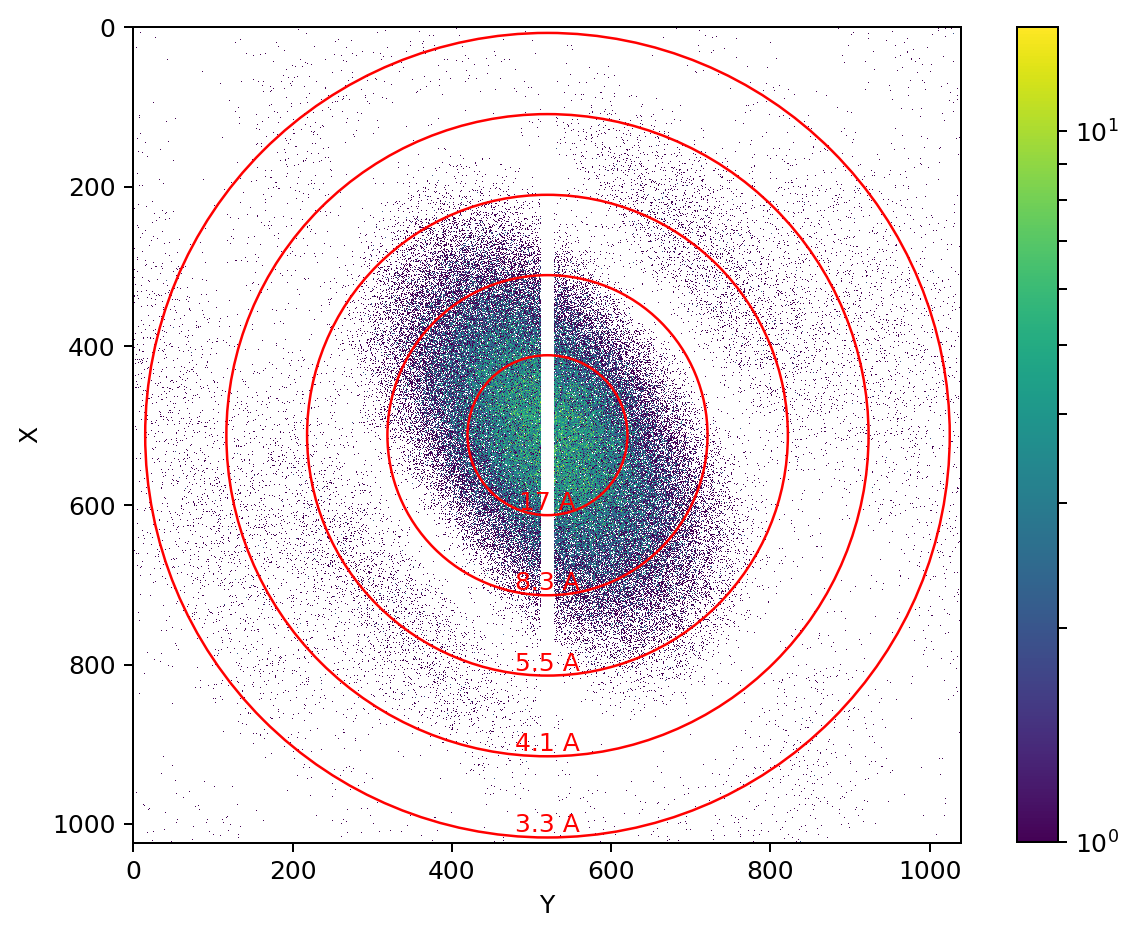

In [8]:
experiment = ps.SPIExperiment(det, beam, particle)
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
fig = plt.figure(figsize=(8, 6), dpi=180)
viz.imshow(experiment.generate_image())

Deform and witness effect on pattern

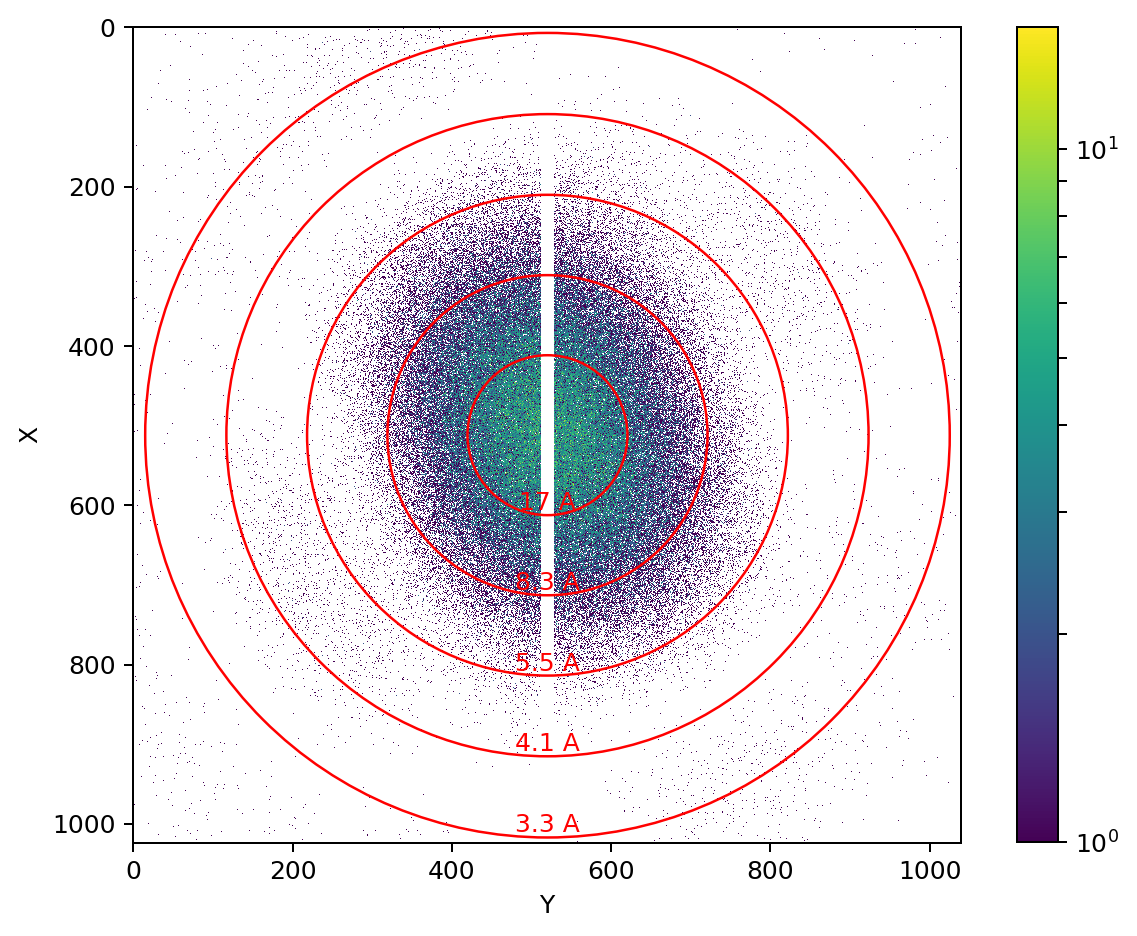

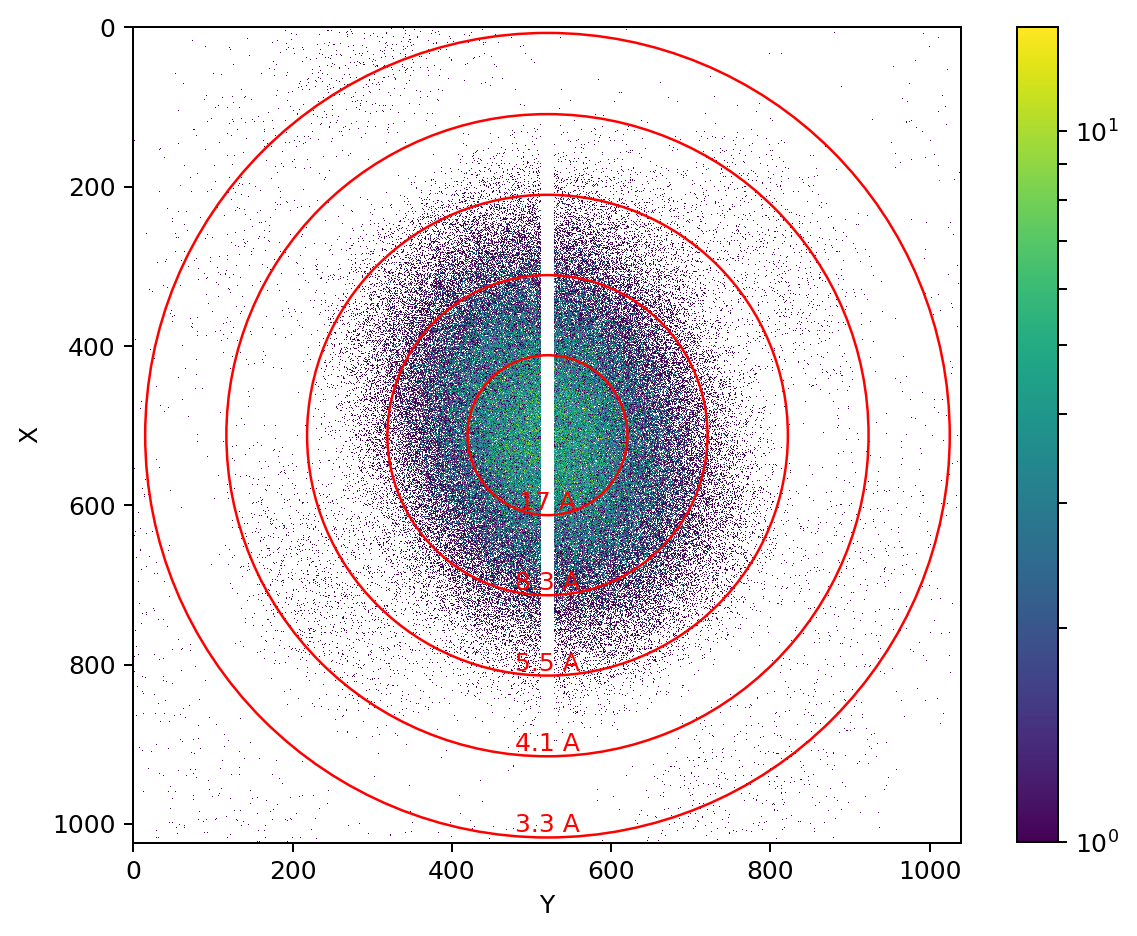

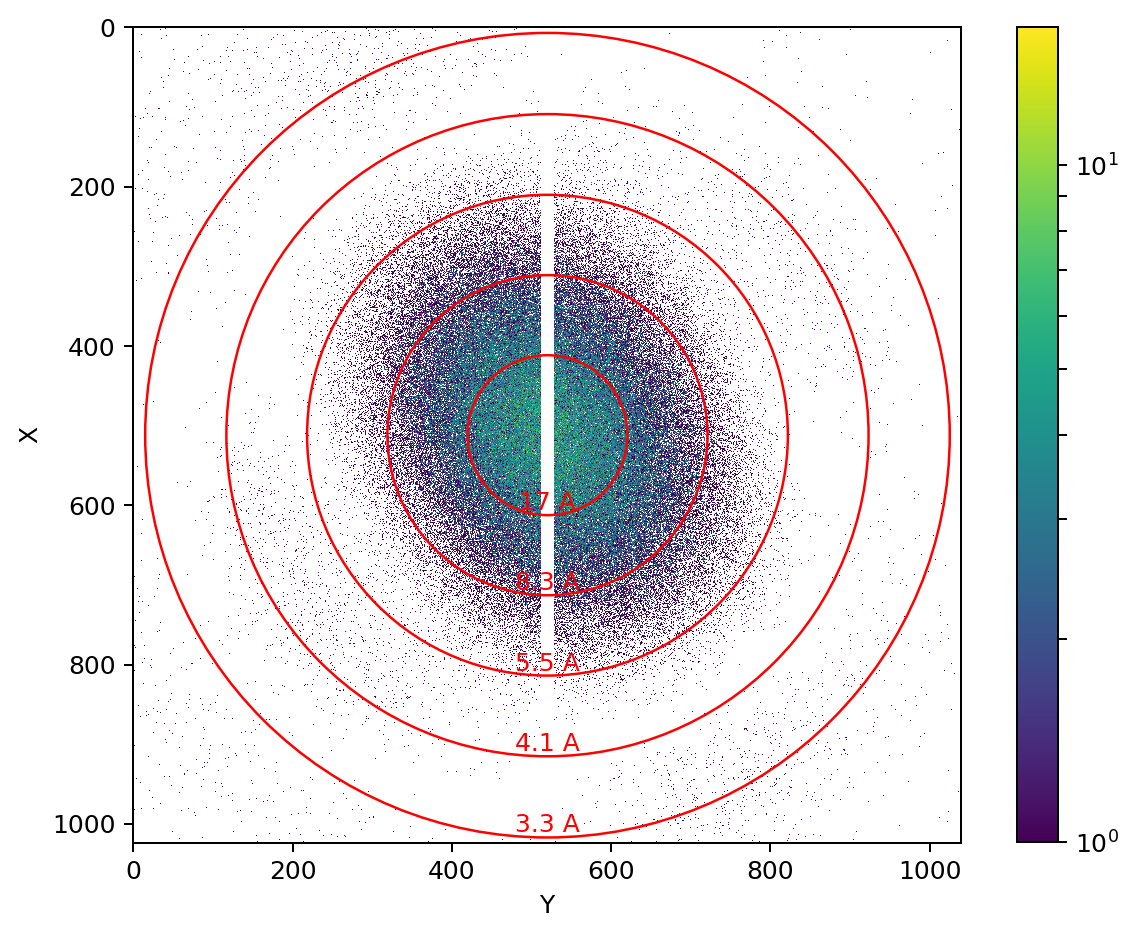

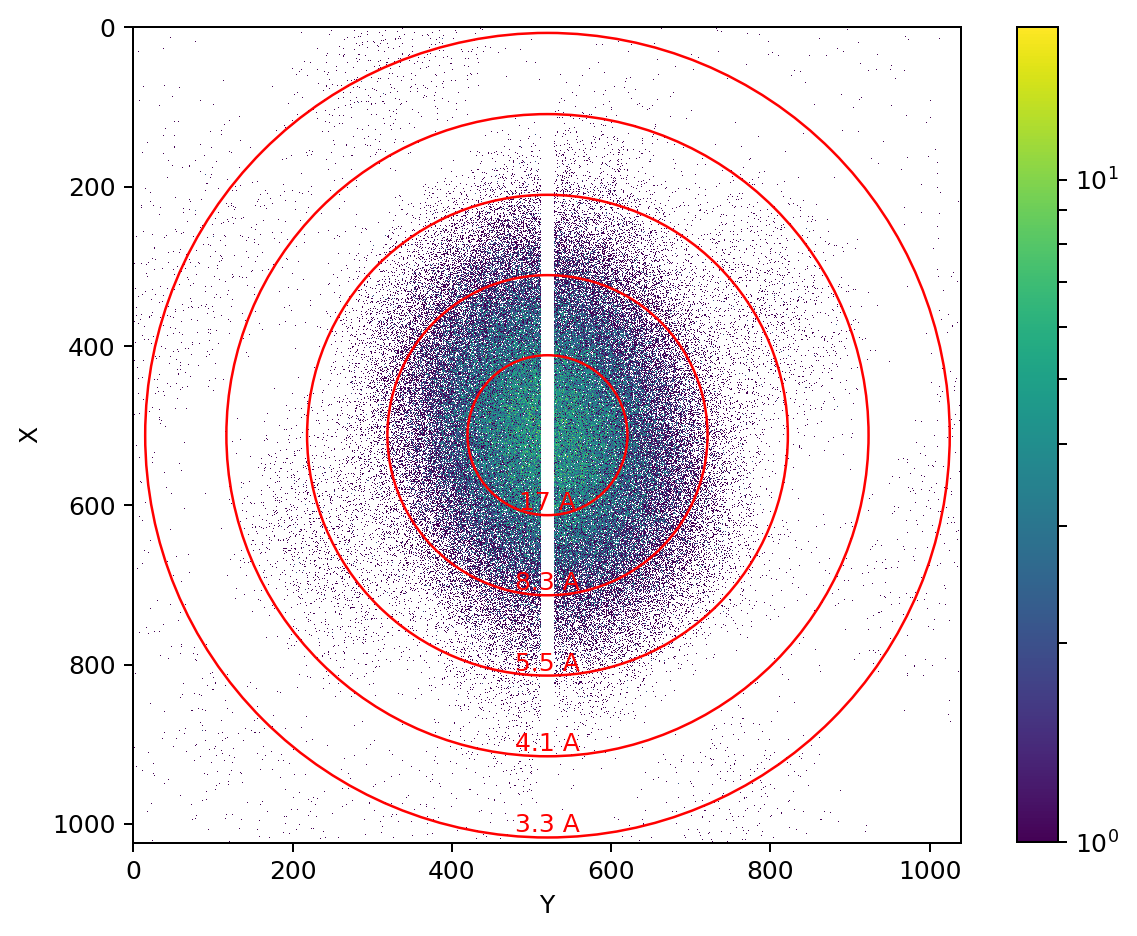

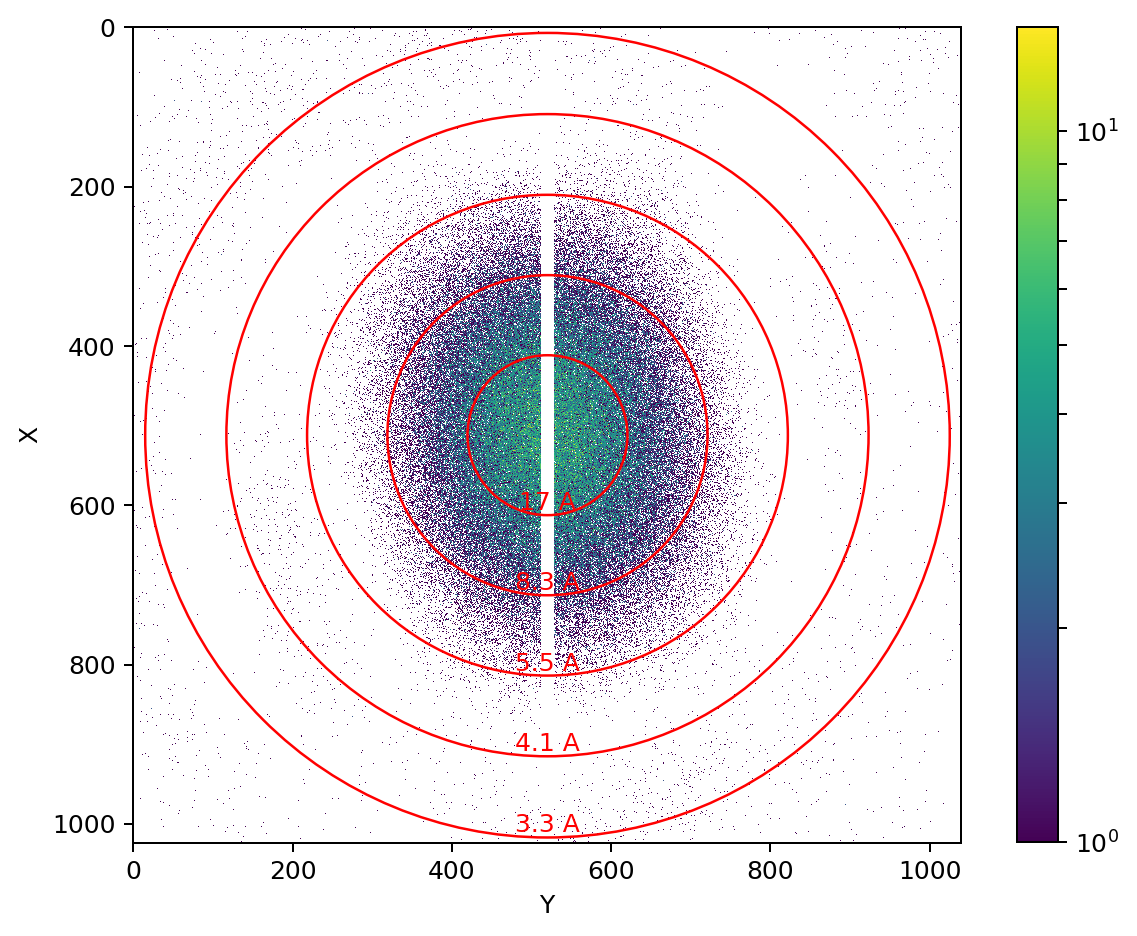

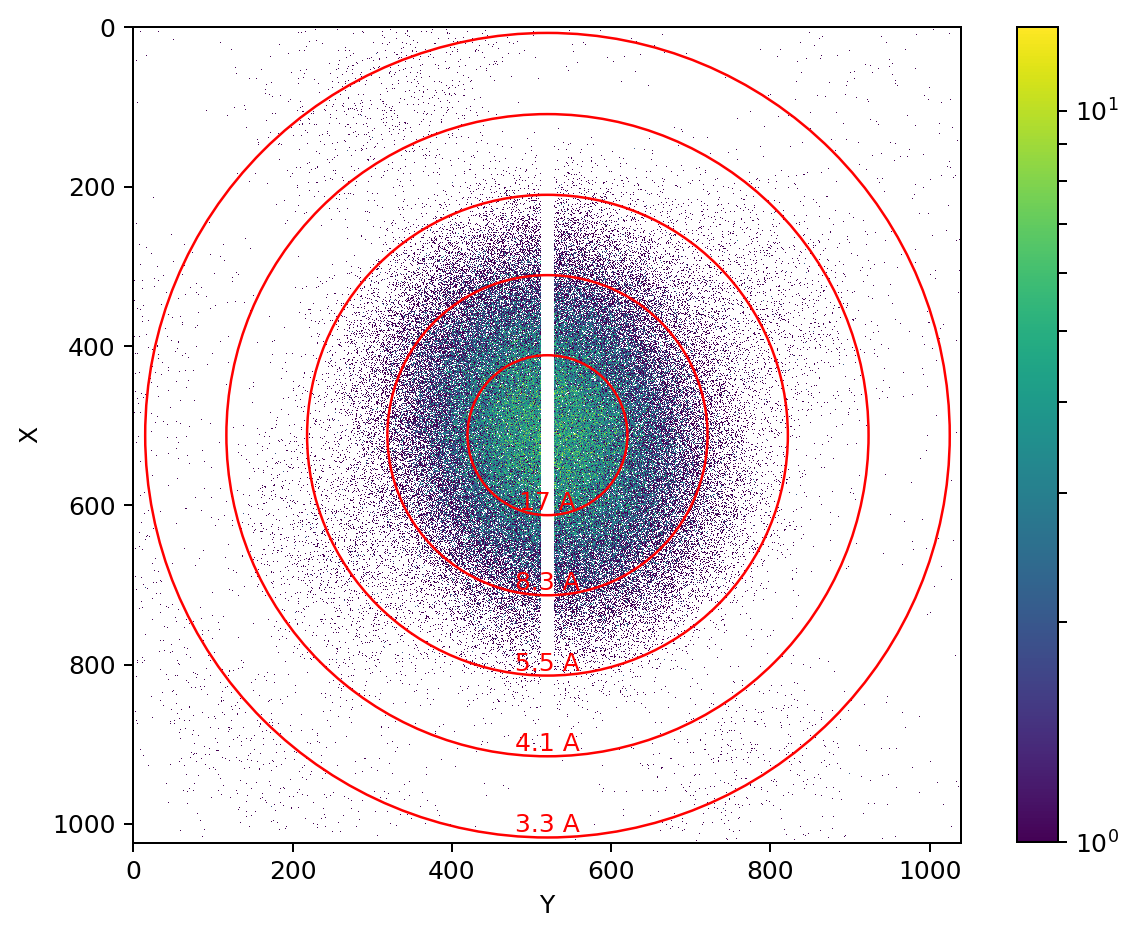

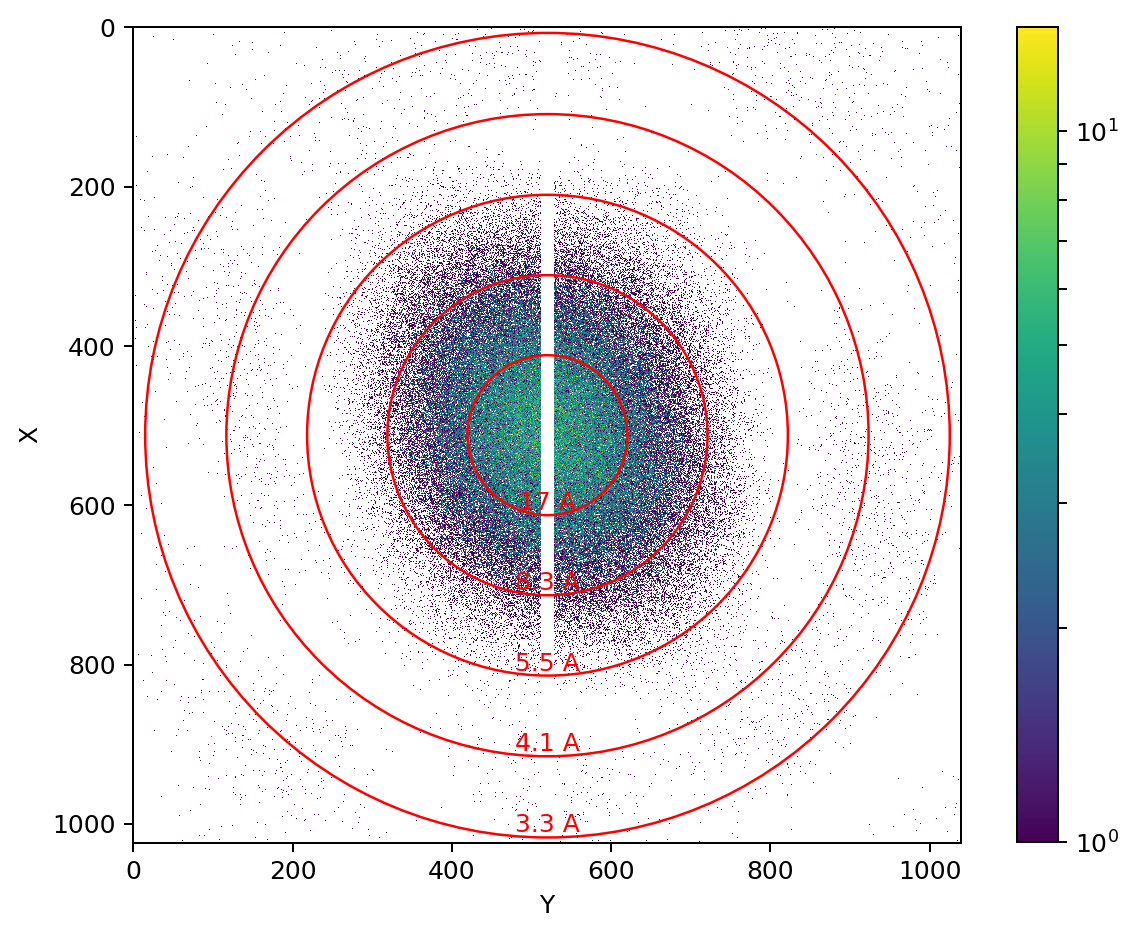

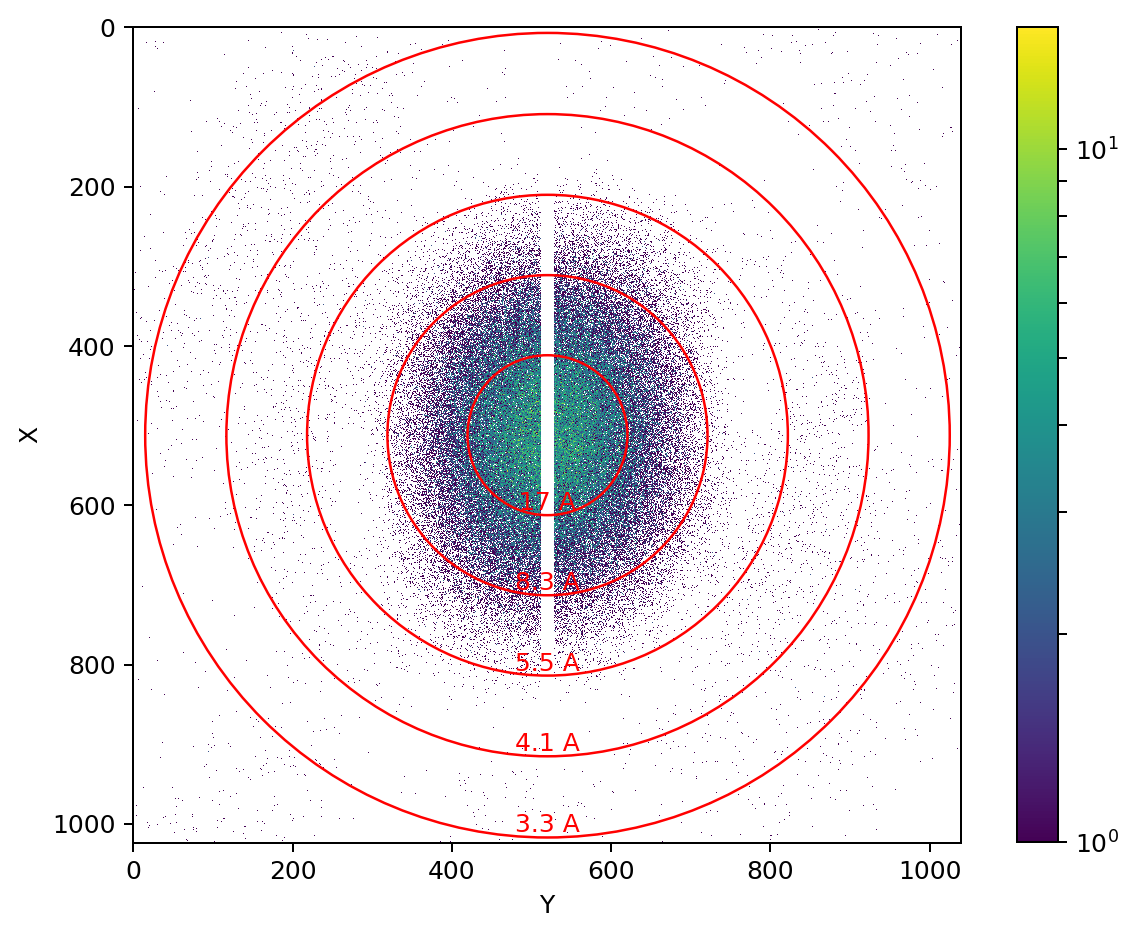

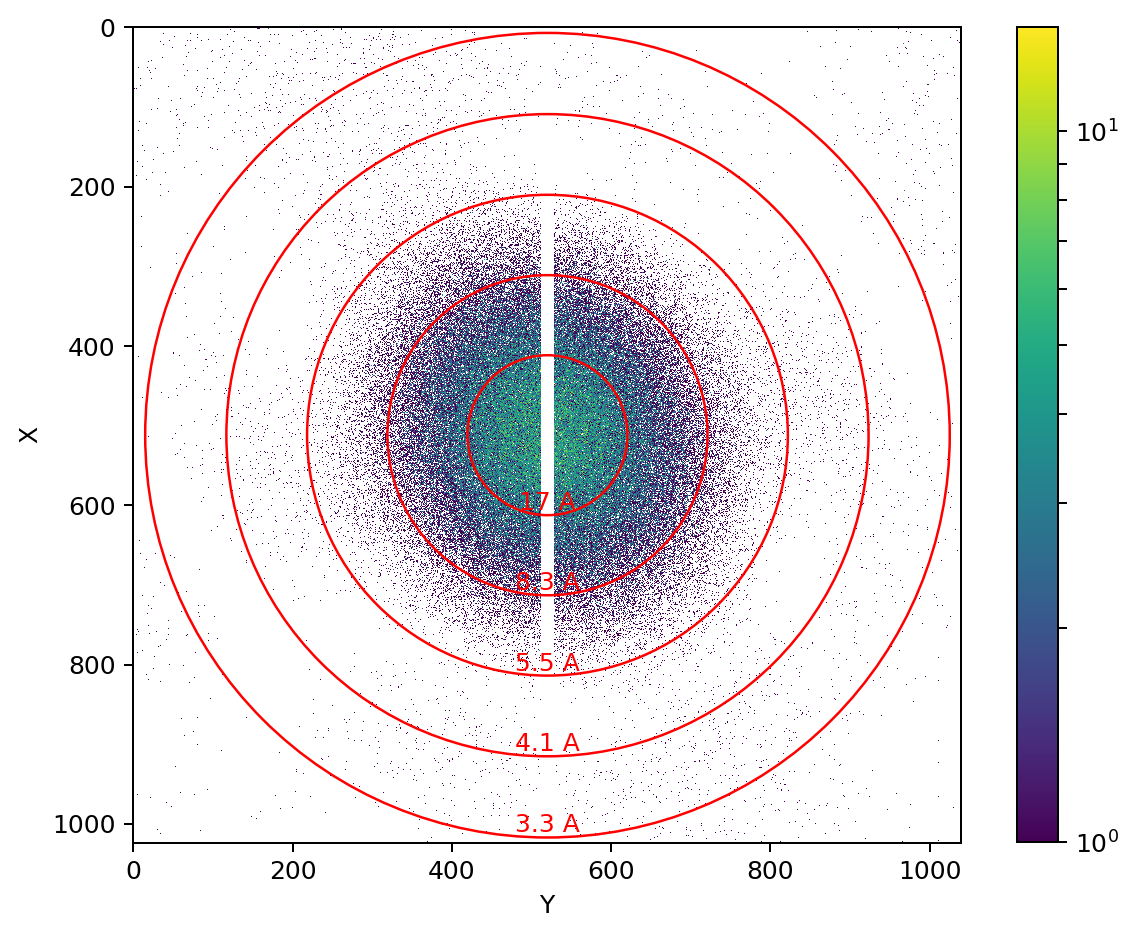

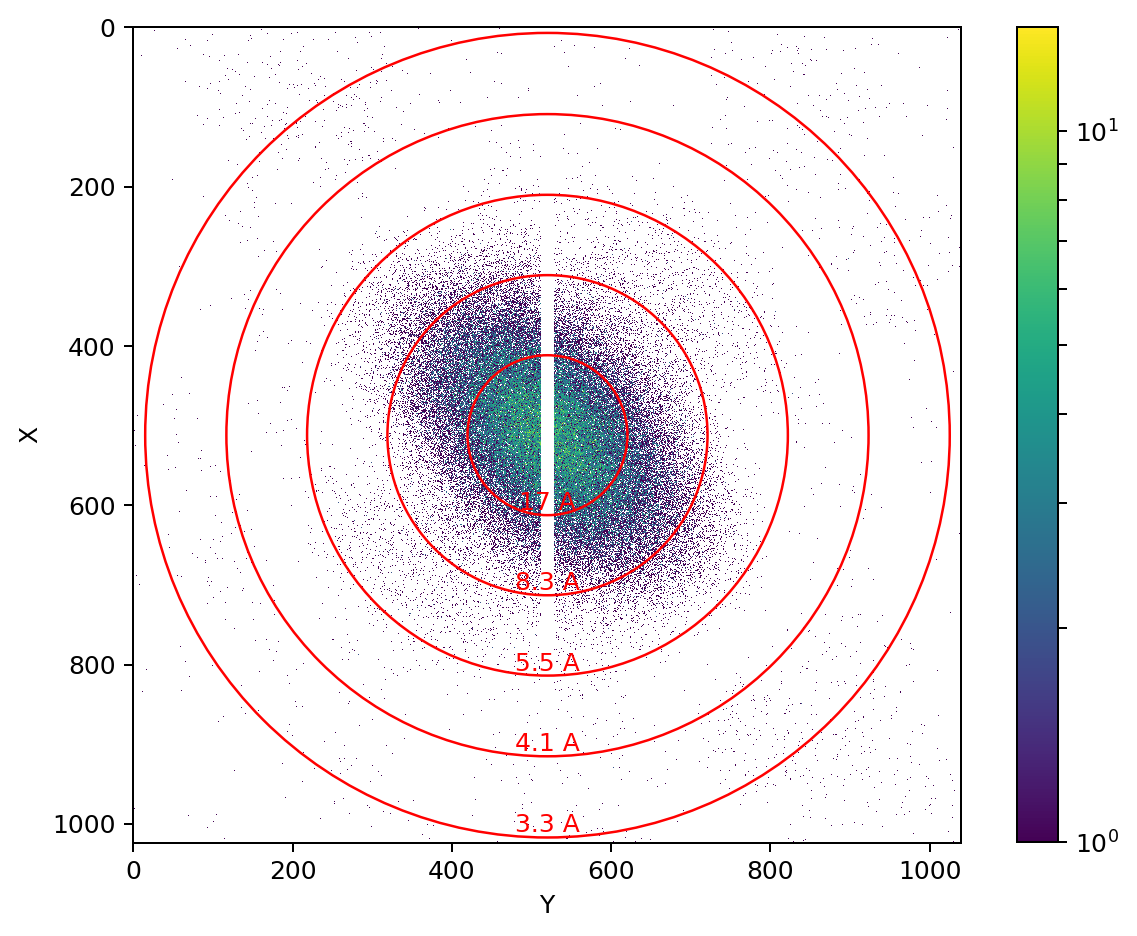

In [9]:
# fix the orientation
orientation = experiment.get_next_orientation()
# save the reference atom positions
atom_pos_save = particle.atom_pos
# compute the normal modes
particle.get_normal_modes()
# deform up to 20A RMSD in steps of 2A
for rmsd in np.arange(0., 20., 2.):
    particle.set_atom_pos(atom_pos_save)
    updated_conformation = particle.update_conformation(rmsd=rmsd)
    particle.set_atom_pos(updated_conformation)
    experiment = ps.SPIExperiment(det, beam, particle, orientations=orientation)
    viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
    fig = plt.figure(figsize=(8, 6), dpi=180)
    viz.imshow(experiment.generate_image())